# Pydough LLM Demo

This notebook showcases how an LLM can generate PyDough queries from natural language instructions. The goal is to demonstrate how AI can automate complex data analysis, making querying faster, more intuitive, and accessible without needing deep technical expertise.

Each example highlights different capabilities, including aggregations, filtering, ranking, and calculations across multiple collections.

---
## Setup & Basic Usage of the API

First, we import the created client.

In [1]:
from llm_v2 import LLMClient

We can declare global definitions that will be useful for any question that needs them.

In [2]:
definitions = [
    "Total Order Value is defined as the sum of extended_price * (1 - discount).",
    "Aggregate Revenue is defined as the sum of LineItem_ExtendedPrice minus the sum of LineItem_Discount.",
    "Average Revenue per Ship Date is defined as the sum of revenue divided by the count of distinct ship dates.",
    "Partial Revenue is defined as quantity * extended_price * (1 - discount).",
    "Profit is defined as revenue minus cost."
]

Then we initialize the client.

In [3]:
client = LLMClient(definitions=definitions)

One should use the `ask()` method to make a query to the model.

We get a `result` object with the next attributes: 

- `code`:  The PyDough query generated by the LLM.
- `full_explanation`: An explanation of how the model solved the query.
- `df`:The dataframe containing the query results.
- `exception`: Stores any errors encountered while executing the query.
- `original_question`: The natural language question input by the user.
- `sql`: The SQL equivalent of the generated PyDough query.
- `base_prompt`: The initial instruction given to the LLM to generate the query.
- `cheat_sheet`:  A reference guide and example queries to help the LLM structure responses.
- `knowledge_graph`: The metadata structure that informs the LLM about available collections and relationships.

---
## First query

Ask method asks a simple query (no discourse mode)

In [12]:
result = client.ask("Give me the name of all the suppliers from the United States")

suppliers_from_usa = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(supplier_name=name)


After that, we can consult all the necessary atributes from the result.

Initially, I want to check the **base instruction** that guided the LLM.

In [13]:
print(result.base_prompt)

<task_description>
You are an AI assistant tasked with converting natural language descriptions into PyDough code snippets. Your goal is to generate accurate and efficient PyDough code that can execute the requested database operations based on the provided natural language description. 
</task_description>

<context>
To assist you in this task, you will be provided with the following context:

1. **PyDough Reference File**  
This file contains the core concepts, functions, and syntax of the PyDough language. It serves as a reference for understanding the PyDough syntax and structure.

{script_content}

2. **Database Structure Reference File**  
This file outlines the database schema, collections, fields, and relationships. It provides information about the underlying data structure and organization.

{database_content}

3. **Examples for Context**  
Here are some examples of PyDough code snippets along with their corresponding natural language questions. These examples can help contex

We can also ask for the for the **pydough code** directly.

In [14]:
print(result.code)

suppliers_from_usa = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(supplier_name=name)


And if we want to compare, we can get the **equivalent SQL query** created by Pydough.

In [15]:
print(result.sql)

SELECT
  name AS supplier_name
FROM (
  SELECT
    s_name AS name,
    s_nationkey AS nation_key
  FROM main.SUPPLIER
)
INNER JOIN (
  SELECT
    key
  FROM (
    SELECT
      n_name AS name,
      n_nationkey AS key
    FROM main.NATION
  )
  WHERE
    name = 'UNITED STATES'
)
  ON nation_key = key


If we want to visually check, analyze or edit the resulting **dataframe**, we also can. There is a dedicated section for this later. on the document

In [16]:
result.df

,supplier_name
0,Supplier#000000010
1,Supplier#000000019
2,Supplier#000000046
3,Supplier#000000049
4,Supplier#000000055
...,...
388,Supplier#000009819
389,Supplier#000009829
390,Supplier#000009859
391,Supplier#000009906


We can also get an **explanation** of how the model solved the query.

In the future, we will offer an English-only explanation to learn more about what the query is about, but for now, you can view a combined PyDough and English explanation generated by the LLM.


In [17]:
print(result.full_explanation)

Okay, let's break this down into smaller parts.

1.  We need to access the `suppliers` collection.
2.  We need to filter the suppliers to only include those from the "UNITED STATES".
3.  We need to extract the `name` of the suppliers.

Here's the PyDough code:

```python
suppliers_from_usa = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(supplier_name=name)
```

Explanation:

*   `suppliers.WHERE(nation.name == "UNITED STATES")`: This filters the suppliers to only include those where the nation's name is "UNITED STATES".
*   `.CALCULATE(supplier_name=name)`: This selects the `name` of the suppliers and assigns it to the `supplier_name` field.



We can also check the original natural language **question** that was asked.

In [18]:
print(result.original_question)

Give me the name of all the suppliers from the United States


We also have a reference guide or **cheat_sheet** with example queries to help structure responses.

In [19]:
print(result.cheat_sheet)

## **PYDOUGH CHEAT SHEET**  
This cheat sheet is a context for learning how to create PyDough code. You must follow all the written rules. Each section represents important features and rules to keep in mind when developing PyDough code. 

### **GENERAL RULES**: 

  - This is NOT SQL, so don't make assumptions about its syntax or behavior.

  - Always use TOP_K instead of ORDER_BY when you need to order but also select a the high, low or an specific "k" number of records.

  - If a query does not specify an specific year, and want that you calculate for all the year, for example “compare year over year”, then the requested calculation must be performed for each year available in TPC: 1995, 1996, 1995 and 1998. You need to use SINGULAR function to call every year in the final result. 

  - If you need to use an attribute of a previous collection, you must have calculated the attribute using CALCULATE.

  - CALCULATE ONLY supports singular expressions. If you need to use plural sub-colle

Now, we will try a new example, this one has an **exception**.

---

## Query correction (early preview)

To try to correct a response with execution problems in PyDough, we can use the `correct()` method. 

In [20]:
result = client.ask("For each of the 5 largest part sizes, find the part of that size with the highest retail price")

print(result.full_explanation)

top_5_sizes = parts.CALCULATE(size=size, retail_price=retail_price).TOP_K(5, by=size.DESC())

result = PARTITION(top_5_sizes, name='part_group', by=size).CALCULATE(
    size=size,
    part_with_highest_price=part_group.TOP_K(1, by=retail_price.DESC())
)
Okay, let's break this down into smaller parts.

1.  Find the 5 largest part sizes.
2.  For each of those sizes, find the part with the highest retail price.

Here's the PyDough code:

```python
top_5_sizes = parts.CALCULATE(size=size, retail_price=retail_price).TOP_K(5, by=size.DESC())

result = PARTITION(top_5_sizes, name='part_group', by=size).CALCULATE(
    size=size,
    part_with_highest_price=part_group.TOP_K(1, by=retail_price.DESC())
)
```

Explanation:

1.  `top_5_sizes = parts.CALCULATE(size=size, retail_price=retail_price).TOP_K(5, by=size.DESC())`: This line selects the top 5 largest part sizes along with their retail prices.
2.  `PARTITION(top_5_sizes, name='part_group', by=size)`: This partitions the `top_5_sizes` collect

If one calls the dataframe and gets an error, no response, or a empty dataframe, it is possible that there is a PyDough exception. We can check this by running:

In [21]:
print(result.exception)

Traceback (most recent call last):
  File "/home/gerald8525/repositories/text2pydough/workbench/AAraya/dev/llm_v2.py", line 175, in get_pydough_sql
    result_sql = pydough.to_sql(last_variable)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gerald8525/anaconda3/envs/aisuite_deepseek/lib/python3.12/site-packages/pydough/evaluation/evaluate_unqualified.py", line 130, in to_sql
    qualified: PyDoughQDAG = qualify_node(node, graph, config)
                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gerald8525/anaconda3/envs/aisuite_deepseek/lib/python3.12/site-packages/pydough/unqualified/qualification.py", line 835, in qualify_node
    return qual.qualify_node(
           ^^^^^^^^^^^^^^^^^^
  File "/home/gerald8525/anaconda3/envs/aisuite_deepseek/lib/python3.12/site-packages/pydough/unqualified/qualification.py", line 786, in qualify_node
    answer = self.qualify_calculate(unqualified, context, is_child)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

You can try to fix the error using the `correct` method. We are going to declare a new variable to obtain the corrected result. 

In [22]:
corrected_result = client.correct(result)

top_5_sizes = parts.CALCULATE(size=size, retail_price=retail_price).TOP_K(5, by=size.DESC())

result = PARTITION(top_5_sizes, name='part_group', by=size).CALCULATE(
    size=size,
    highest_price=MAX(part_group.retail_price)
).part_group.CALCULATE(
    part_with_highest_price=parts.WHERE(size == size).WHERE(retail_price == highest_price).name
)


To see how the model try to solve the issue, you can print the full explanation of the `corrected_result`.

In [10]:
print(corrected_result.full_explanation)

Okay, I understand the error and the goal. The error "Unrecognized term of simple table collection 'parts' in graph 'TPCH': 'parts'" indicates that you're trying to use the collection `parts` as a term within the `PARTITION` function, which is not allowed. The `by` parameter in `PARTITION` should only contain expressions, not collections. Also, the logic was not correct, you don't need to partition.

Here's the corrected PyDough code:

```python
top_5_sizes = parts.CALCULATE(part_size=size, part_retail_price=retail_price).TOP_K(5, by=size.DESC()).CALCULATE(size=size, max_price_part=retail_price).TOP_K(5, by=size.DESC())
```

Explanation:

1.  **`parts.CALCULATE(part_size=size, part_retail_price=retail_price)`**: This line selects the `parts` collection and creates new fields `part_size` and `part_retail_price` to store the size and retail price of each part.
2.  **`.TOP_K(5, by=size.DESC())`**: This selects the top 5 parts based on their `size` in descending order.
3.  **`.CALCULATE(si

---
## Post-processing dataframe

Once the DataFrame is generated, it can be analysed or manipulated just like any other dataframe, using **any** Python package for analysis, visualization, or transformation. 

This is a planned future feature, and one of the core differentiators of PyDough!

As a first example, in this section we manipulate a resulting dataframe with pandas and matplotlib to create a histogram and a boxplot of the different orders prices.

In [25]:
result = client.ask("Give me all the order prices, name the column total_price.")

result.df

order_prices = orders.CALCULATE(total_price=total_price)


,total_price
0,173665.47
1,46929.18
2,193846.25
3,32151.78
4,144659.20
...,...
1499995,114856.68
1499996,68906.56
1499997,92750.90
1499998,63216.65


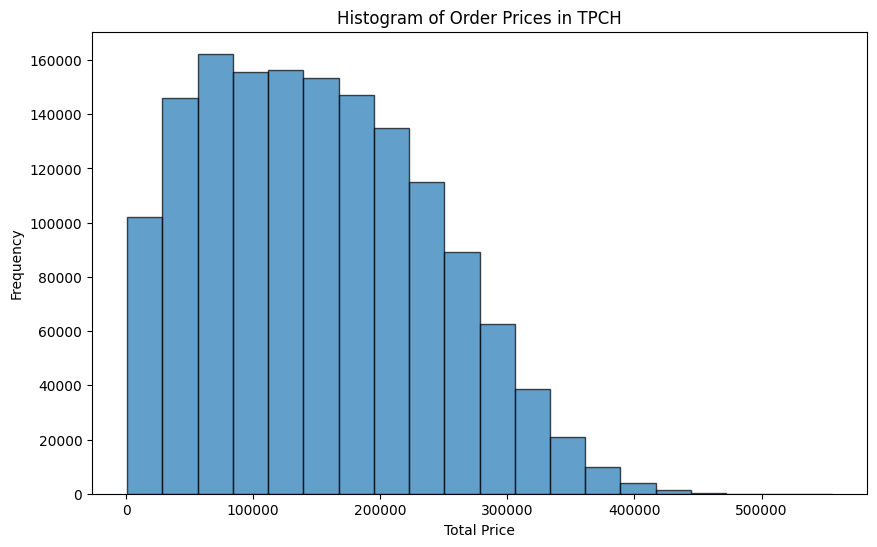

In [26]:
import matplotlib.pyplot as plt

df= result.df

plt.figure(figsize=(10, 6))
plt.hist(df["total_price"], bins=20, edgecolor="black", alpha=0.7)

# Configurar etiquetas y título
plt.xlabel("Total Price")
plt.ylabel("Frequency")
plt.title("Histogram of Order Prices in TPCH")

# Mostrar el gráfico
plt.show()

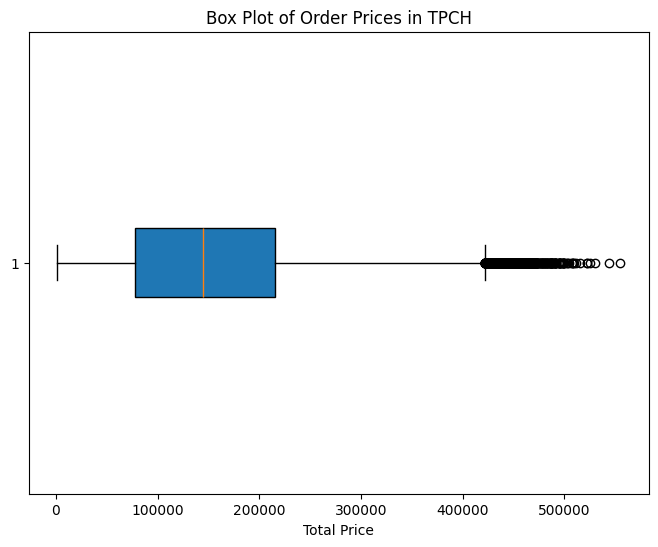

In [27]:
# Create a box plot for order prices
plt.figure(figsize=(8, 6))
plt.boxplot(df["total_price"], vert=False, patch_artist=True)

# Configure labels and title
plt.xlabel("Total Price")
plt.title("Box Plot of Order Prices in TPCH")

# Show the plot
plt.show()

---
## Query Quality and Verification

In the future we will be able to take the PyDough code, the user question, the knowledge graph and the generated data frame to perform semantic tests that will help assure the quality of the results. Some ideas that are under evaluation: 

1. John's graph reconstruction / deconstruction / verification ideas
2. LLM based rules that allow us to confirm certain properties of the Data Frame
   a. If the user requires a top 5 result, then the resulting DF must have 5 rows.
3. Program slicing ideas:
   b. If each cell can be traced to a transformation, look at the transformation and match it against the query (this is connected to John's ideas)
4. Emsemble ideas many variations prompts and LLMs could help us compare multiple results.
5. Talk about why Greg is flabbergasted. 

Here we show a simple demonstration of taking the resulting PyDough code, and then generating structured data from it so that you can compare the variables it used, against the original variables in our Knowledge Graph.

In [28]:
import ast
import json
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

class DSLGraphBuilder:
    class VariableNameExtractor(ast.NodeVisitor):
        def __init__(self):
            self.names = set()
        def visit_Name(self, node):
            # Ignore uppercase identifiers (like COUNT or YEAR)
            if not node.id.isupper():
                self.names.add(node.id)
            self.generic_visit(node)
    
    @staticmethod
    def extract_calculate_rhs_names(code):
        """
        Parse a DSL snippet and extract variable names from the right-hand side 
        of CALCULATE keyword assignments.
        """
        tree = ast.parse(code)
        names = set()
        for node in ast.walk(tree):
            if (
                isinstance(node, ast.Call)
                and isinstance(node.func, ast.Attribute)
                and node.func.attr == "CALCULATE"
            ):
                for kw in node.keywords:
                    extractor = DSLGraphBuilder.VariableNameExtractor()
                    extractor.visit(kw.value)
                    names.update(extractor.names)
        return names
    
    @classmethod
    def build_graph_from_snippets(cls, snippets):
        """
        Build a co-occurrence graph where each variable (from CALCULATE calls) 
        is a node, and an edge connects any two variables that appear together in a snippet.
        """
        all_nodes = set()
        snippet_vars = []  # list of sets of variable names per snippet
        for code in snippets:
            vars_in_snippet = cls.extract_calculate_rhs_names(code)
            snippet_vars.append(vars_in_snippet)
            all_nodes.update(vars_in_snippet)
        
        nodes = [{"id": var, "label": var} for var in sorted(all_nodes)]
        edges = []
        added_edges = set()
        for vars_in_snippet in snippet_vars:
            for a, b in combinations(sorted(vars_in_snippet), 2):
                key = tuple(sorted((a, b)))
                if key not in added_edges:
                    added_edges.add(key)
                    edges.append({"source": key[0], "target": key[1]})
        return {"nodes": nodes, "edges": edges}
    
    @staticmethod
    def visualize_graph(graph):
        """
        Visualize the graph using NetworkX and Matplotlib.
        """
        G = nx.Graph()
        for node in graph["nodes"]:
            G.add_node(node["id"])
        for edge in graph["edges"]:
            G.add_edge(edge["source"], edge["target"])
        
        # Use spring layout for a visually appealing graph
        pos = nx.spring_layout(G)
        
        plt.figure(figsize=(8, 6))
        nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue", edgecolors="black")
        nx.draw_networkx_edges(G, pos)
        nx.draw_networkx_labels(G, pos, font_size=10)
        
        plt.title("Co-occurrence Graph of Variables", fontsize=14)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

Now, this can be used to analyse the PyDough code that was first generated.

{
    "nodes": [
        {
            "id": "acctbal",
            "label": "acctbal"
        },
        {
            "id": "name",
            "label": "name"
        },
        {
            "id": "order_date",
            "label": "order_date"
        },
        {
            "id": "orders",
            "label": "orders"
        }
    ],
    "edges": [
        {
            "source": "acctbal",
            "target": "name"
        },
        {
            "source": "acctbal",
            "target": "order_date"
        },
        {
            "source": "acctbal",
            "target": "orders"
        },
        {
            "source": "name",
            "target": "order_date"
        },
        {
            "source": "name",
            "target": "orders"
        },
        {
            "source": "order_date",
            "target": "orders"
        }
    ]
}


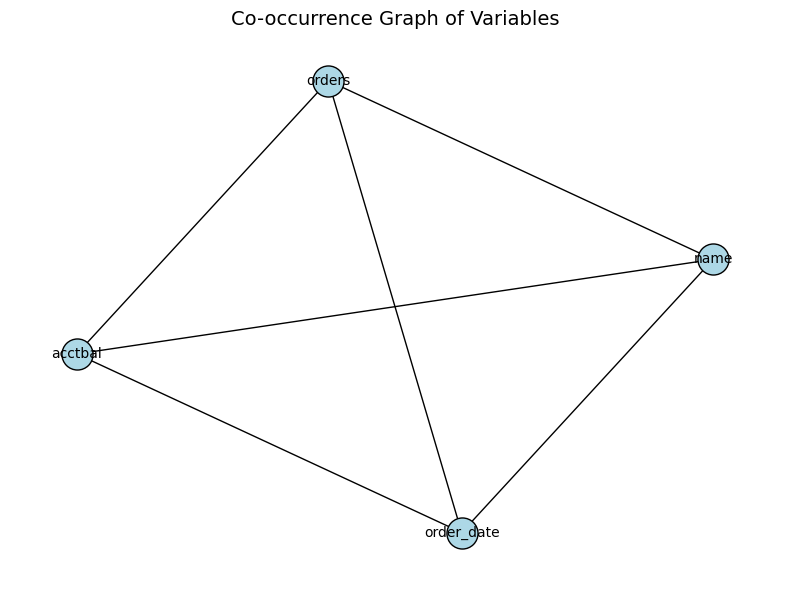

In [29]:
# Using the DSLGraphBuilder defined in a previous cell
builder = DSLGraphBuilder()

# Define your DSL code snippets to analyse

snippet1 = '''# Find all suppliers from the United States
us_suppliers = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(
    supplier_name=name
)
'''
snippet2 = '''# Identify orders in 1995
orders_1995 = orders.WHERE(YEAR(order_date) == 1995)
european_customers = customers.CALCULATE(
    customer_name=name,
    account_balance=acctbal,
    num_orders_1995=COUNT(orders.WHERE(YEAR(order_date) == 1995))
).WHERE(
    (nation.region.name == "EUROPE") &
    (acctbal > 700) &
    (num_orders_1995 > 0)
)
'''

snippets = [snippet1, snippet2]

# Build the graph structure from your snippets
graph = builder.build_graph_from_snippets(snippets)

# Print out the graph JSON structure if desired
import json
print(json.dumps(graph, indent=4))

# Visualize the graph using matplotlib and networkx
builder.visualize_graph(graph)

---
That generates a graphical view of the variables, and the co-occurence, and a json with that information, which can be compared against the original json knowledge graph for verification.

NB: This is only a first exploratory step, but as we have better ideas on verification, we will be able to add and extend this segment. Which is why it's an entire workstream as planned in our roadmap.

Now, on to more test cases!

---

## Test Cases

Let's now look at a few more test cases and see how PyDough and PyDough LLM does.

### Customer Segmentation

### 1. Find the names of all customers and the number of orders placed in 1995 in Europe.

- Demonstrates simple filtering, counting, and sorting while being business-relevant for regional market analysis. 
- Adds a second filtering layer by including account balance and order activity, making it more dynamic.

In [40]:
query = "Find the names of all customers and the number of their orders placed in 1995 in Europe."

result = client.ask(query)

print(result.full_explanation)
result.df.head()

european_customer_orders = regions.WHERE(name == "EUROPE").nations.customers.CALCULATE(
    customer_name=name,
    num_orders_1995=COUNT(orders.WHERE(YEAR(order_date) == 1995))
)
Okay, let's break this down into smaller parts.

1.  We need to find customers in Europe.
2.  For each of these customers, we need to count the number of orders they placed in 1995.
3.  We need to return the customer's name and the number of orders.

Here's how we can approach this:

1.  Start with the `regions` collection and filter for "EUROPE".
2.  From Europe, access the `nations`.
3.  From nations, access the `customers`.
4.  From customers, access the `orders` and filter for the year 1995.
5.  Count the number of orders for each customer.
6.  Return the customer's name and the order count.

```python
european_customer_orders = regions.WHERE(name == "EUROPE").nations.customers.CALCULATE(
    customer_name=name,
    num_orders_1995=COUNT(orders.WHERE(YEAR(order_date) == 1995))
)
```

This code:

1.  Start

,customer_name,num_orders_1995
0,Customer#000000011,1
1,Customer#000000015,0
2,Customer#000000018,0
3,Customer#000000020,3
4,Customer#000000026,2


**Follow up**: Now, give me the ones who have an account balance greater than $700 and placed at least one order in that same year. Sorted in descending order by the number of orders.

In [45]:
result2 = client.discourse(result, 
"""Now, give me the ones who have an account balance greater than $700 and placed at least one order in that same year. 
Sorted in descending order by the number of orders.""")

print(result2.full_explanation)
result2.df.head()

european_customer_orders = regions.WHERE(name == "EUROPE").nations.customers.CALCULATE(
    customer_name=name,
    num_orders_1995=COUNT(orders.WHERE(YEAR(order_date) == 1995)),
    account_balance=acctbal
).WHERE((account_balance > 700) & (num_orders_1995 > 0)).ORDER_BY(num_orders_1995.DESC())
```python
european_customer_orders = regions.WHERE(name == "EUROPE").nations.customers.CALCULATE(
    customer_name=name,
    num_orders_1995=COUNT(orders.WHERE(YEAR(order_date) == 1995)),
    account_balance=acctbal
).WHERE((account_balance > 700) & (num_orders_1995 > 0)).ORDER_BY(num_orders_1995.DESC())
```

**Explanation:**

1.  **Start with the base query:** We begin with the previously generated code that finds customers in Europe and calculates their order count in 1995.
2.  **Add account balance:** We include the `account_balance` in the initial `CALCULATE` to make it available for filtering.
3.  **Filter by account balance and order count:** We add a `WHERE` clause to filter the results

,customer_name,num_orders_1995,account_balance
0,Customer#000107440,12,2464.61
1,Customer#000014920,11,7026.03
2,Customer#000079606,11,989.51
3,Customer#000108496,11,7388.38
4,Customer#000009019,10,2247.06


### 2. List customers who ordered in 1996 but not in 1997, with a total spent of over 1000$?

- Showcases PyDough’s HAS() and HASNOT() functions, helping analyze customer retention and spending patterns. 
- Also incorporates a time-based calculation.

In [12]:
query = "List customers who ordered in 1996 but not in 1997 with a total spent of over $1000."

result = client.ask(query)

print(result.full_explanation)
result.df.head()

customers_1996_not_1997_over_1000 = customers.WHERE(
    (HAS(orders.WHERE(YEAR(order_date) == 1996))==1) &
    (HASNOT(orders.WHERE(YEAR(order_date) == 1997))==1)
).CALCULATE(
    customer_name=name,
    total_spent=SUM(orders.total_price)
).WHERE(total_spent > 1000)
Okay, let's break this down into smaller parts.

1.  **Customers who ordered in 1996:** We need to identify customers who have orders with `order_date` in 1996.
2.  **Customers who did not order in 1997:** We need to exclude customers who have orders with `order_date` in 1997.
3.  **Total spent over $1000:** We need to filter customers based on the sum of their orders' `total_price` being greater than $1000.

Here's the PyDough code:

```python
customers_1996_not_1997_over_1000 = customers.WHERE(
    (HAS(orders.WHERE(YEAR(order_date) == 1996))==1) &
    (HASNOT(orders.WHERE(YEAR(order_date) == 1997))==1)
).CALCULATE(
    customer_name=name,
    total_spent=SUM(orders.total_price)
).WHERE(total_spent > 1000)
```

Explanat

,customer_name,total_spent
0,Customer#000000005,684965.28
1,Customer#000000017,1379590.03
2,Customer#000000020,2073301.93
3,Customer#000000031,3063979.39
4,Customer#000000038,1704201.88


**Follow up**: Now, include the number of months since the last order and sort by total spent, highest first.

In [27]:
result2 = client.discourse(result,
"Now, include the number of months since the last order and sort by total spent, highest first.")

print(result2.full_explanation)
result2.df.head()

customers_1996_not_1997_over_1000 = customers.WHERE(
    (HAS(orders.WHERE(YEAR(order_date) == 1996))==1) &
    (HASNOT(orders.WHERE(YEAR(order_date) == 1997))==1)
).CALCULATE(
    customer_name=name,
    total_spent=SUM(orders.total_price),
    last_order_date=MAX(orders.order_date)
).CALCULATE(
    months_since_last_order=DATEDIFF("months", last_order_date, DATETIME('now')),
    customer_name=customer_name,
    total_spent=total_spent
).ORDER_BY(total_spent.DESC())
Okay, I will modify the previous query to include the number of months since the last order and sort the results by total spent in descending order.

Here's the breakdown:

1.  **Base Query**: Start with the existing query that identifies customers who ordered in 1996 but not in 1997 and have a total spent of over $1000.
2.  **Calculate Months Since Last Order**: For each customer, calculate the number of months since their last order. This requires finding the most recent order date and then calculating the difference bet

,months_since_last_order,customer_name,total_spent
0,321,Customer#000001948,5614411.17
1,323,Customer#000047401,5262679.14
2,320,Customer#000094354,5234152.55
3,320,Customer#000120877,5200194.28
4,320,Customer#000012595,4973507.88


### Sales Performance

### 3. Find the region with the highest total order value in 1996.

- The total order value is defined as potential revenue, defined as the sum of extended_price * (1 - discount)
- It introduces precise calculations within the query, ensuring revenue insights.

In [28]:
client.add_definition("Revenue is defined as the sum of quantity * extended_price * (1 - discount) * (1 + tax).")

The new definition has been added to the definition list.


In [4]:
query = "Find the region with the highest revenue in 1996."

result = client.ask(query)

print(result.full_explanation)
result.df.head()

region_highest_revenue_1996 = regions.CALCULATE(
    region_name=name,
    total_revenue=SUM(
        nations.customers.orders.WHERE(YEAR(order_date) == 1996).lines.CALCULATE(
            line_revenue=extended_price * (1 - discount)
        ).line_revenue
    )
).TOP_K(1, by=total_revenue.DESC())
Okay, let's break this down into smaller parts.

1.  **Objective**: Find the region with the highest revenue in 1996.
2.  **Revenue Definition**: We need to calculate revenue, which is defined as the sum of `extended_price * (1 - discount)`.
3.  **Collections**: We'll start with the `regions` collection and navigate through `nations`, `customers`, `orders`, and `lines` to calculate the revenue.
4.  **Filtering**: We need to filter orders for the year 1996.
5.  **Aggregation**: We need to sum the revenue for each region.
6.  **Top K**: Finally, we need to find the region with the highest revenue using `TOP_K`.

Here's the PyDough code:

```python
region_highest_revenue_1996 = regions.CALCULATE(

,region_name,total_revenue
0,EUROPE,6.746079e+09


**Follow up**: Can you compare it now year over year?

In [9]:
result2 = client.discourse(result, "Can you compare it now year over year in Europe?")

print(result2.full_explanation)
result2.df.head()

europe_revenue_1995 = regions.WHERE(name == "EUROPE").CALCULATE(
    region_name=name,
    total_revenue=SUM(
        nations.customers.orders.WHERE(YEAR(order_date) == 1995).lines.CALCULATE(
            line_revenue=extended_price * (1 - discount)
        ).line_revenue
    )
).TOP_K(1, by=total_revenue.DESC())

europe_revenue_1996 = regions.WHERE(name == "EUROPE").CALCULATE(
    region_name=name,
    total_revenue=SUM(
        nations.customers.orders.WHERE(YEAR(order_date) == 1996).lines.CALCULATE(
            line_revenue=extended_price * (1 - discount)
        ).line_revenue
    )
).TOP_K(1, by=total_revenue.DESC())

europe_revenue_1997 = regions.WHERE(name == "EUROPE").CALCULATE(
    region_name=name,
    total_revenue=SUM(
        nations.customers.orders.WHERE(YEAR(order_date) == 1997).lines.CALCULATE(
            line_revenue=extended_price * (1 - discount)
        ).line_revenue
    )
).TOP_K(1, by=total_revenue.DESC())

europe_revenue_1998 = regions.WHERE(name == "EUROPE").C

,year_1995,year_1996,year_1997,year_1998
0,6.701964e+09,6.746079e+09,6.612330e+09,3.955201e+09


### Product Trends

### 4. Which 10 customers purchased the highest quantity of products during 1998?

- Highlights ranking queries, customer segmentation, and purchasing trends. 

In [14]:
query = "Which 10 customers purchased the highest quantity of products during 1998?."

result = client.ask(query)

print(result.full_explanation)
result.df

top_customers_by_quantity = customers.CALCULATE(
    customer_name=name,
    total_quantity=SUM(orders.WHERE(YEAR(order_date) == 1998).lines.quantity)
).TOP_K(10, by=total_quantity.DESC())
Okay, let's analyze this request step by step to generate the PyDough code:

1.  **Objective:** Identify the top 10 customers who purchased the highest quantity of products in 1998.

2.  **Data Source:** We need to start with the `customers` collection and consider their `orders` and the `lines` within those orders to determine the quantity of products purchased.

3.  **Filtering:** We need to filter the orders to only include those placed in 1998.

4.  **Calculation:** For each customer, we need to calculate the total quantity of products purchased in 1998. This involves summing the `quantity` field from the `lines` collection.

5.  **Ranking:** We need to rank the customers based on the total quantity of products purchased and select the top 10.

6.  **Output:** The query should return the top 10 c

,customer_name,total_quantity
0,Customer#000119539,1206
1,Customer#000026518,1158
2,Customer#000024877,1104
3,Customer#000000019,1084
4,Customer#000106000,1058
5,Customer#000102295,1029
6,Customer#000027970,995
7,Customer#000053383,994
8,Customer#000099025,988
9,Customer#000137437,987


**Follow up**: Now return the sum of only the products that have "green" on the product name.

In [25]:
result2 = client.discourse(result, """Now take into account only the products that have "green" in their name""")

print(result2.full_explanation)
result2.df

top_customers_by_green_quantity = customers.CALCULATE(
    customer_name=name,
    total_quantity=SUM(
        orders.WHERE(YEAR(order_date) == 1998).lines.WHERE(CONTAINS(part.name, "green")).quantity
    )
).TOP_K(10, by=total_quantity.DESC())
Okay, I will refine the previous query to only include products that have "green" in their name when calculating the total quantity purchased by each customer in 1998.

Here's the breakdown:

1.  **Start with the `customers` collection.**
2.  **Calculate the `total_quantity` for each customer.** This involves:
    *   Going through each customer's `orders`.
    *   Filtering the orders to only include those from 1998 (`WHERE(YEAR(order_date) == 1998)`).
    *   Accessing the `lines` for each order.
    *   Filtering the lines to only include products with "green" in their name (`WHERE(lines.part.name.CONTAINS("green"))`).
    *   Summing the `quantity` of these filtered lines.
3.  **Select the top 10 customers based on `total_quantity` using `TO

,customer_name,total_quantity
0,Customer#000011509,208
1,Customer#000022147,201
2,Customer#000027577,201
3,Customer#000109117,176
4,Customer#000016252,172
5,Customer#000009139,171
6,Customer#000099187,170
7,Customer#000024817,164
8,Customer#000112678,162
9,Customer#000072490,158
